# Финальный проект: вариант 3

Представьте, что вы работаете в крупном дейтинговом приложении.
Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:
1. Был ли эксперимент успешен в целом.
2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

**Данные**

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:

- `uid` – идентификатор пользователя
- `age` – возраст
- `attraction_coeff` – коэффициент привлекательности (от 0 до 1000, лайки/просмотры*1000)
- `coins` – число монеток (внутренняя валюта)
- `country` – страна 
- `visit_days` – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- `gender` – пол
- `age_filter_start`  – фильтр поиска, мин. значение
- `age_filter_end`  – фильтр поиска, макс. значение
- `views_count` – число полученных оценок
- `was_premium` – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- `is_premium` –  является ли премиум
- `total_revenue` – нормированная выручка 

transactions_*.csv – информация о платежах пользователей:
- `uid` – идентификатор пользователя
- `country` – страна
- `joined_at` – дата и время регистрации
- `paid_at` – дата и время покупки
- `revenue` – нормированная выручка
- `payment_id` – идентификатор платежа
- `from_page` – откуда пользователь перешел на страницу оплаты
- `product_type` – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

**Файлы:**

- users_test – информация о пользователях в тестовой группе.
- users_control_1 – информация о пользователях в первой контрольной группе.
- users_control_2 – информация о пользователях во второй контрольной группе .
- transactions_test – информация о платежах пользователей в тестовой группе.
- transactions_control_1 – информация о платежах пользователей в первой контрольной группе.
- transactions_control_2 – информация о платежах пользователей во второй контрольной группе.

## About dating apps
Прежде чем переходить к выполнению задания проанализируем dating apps: какие цели преследуют приложения и за счет чего зарабатывают. Ведь продукт — это бизнес, а бизнес — это деньги. 

Анализ экономики дейтингового приложения поможет определить какие метрики рассчитать для оценки внесенного изменения.
dating apps позиционируют себя как возможность найти идеального партнера, но это не главная цель продукта. Найдете партнера — перестанете пользоваться приложением. 

Цель приложения: увеличить время использования продукта и стимулирование покупок в приложении. 

Достигнуть этих целей помогут следующие задачи:
1.	Удержать пользователя (Retention Rate and Churn Rate, Stickiness).
2.	Увеличить активность пользователя в приложении (DAU и MAU).
3.	Увеличить количество премиум подписок (CR, ARPU, ARPPU).
4.	Увеличить количество установок.

Следующие метрики помогут отслеживать прогресс по задачам:
1. Основная метрика: 
 - Conversion Rate в покупку премиум подписки без пробного периода (premium_no_trial)
2. Вспомогательные метрики: 
  - ARPU, ARPPU. Позволят оценить выручку и аудиторию: не слишком ли большая скидка или предложение привлекло аудиторию, которая не платит 
  - Retention rate (1, 7 и 28 дня). Чем дольше человек в приложении, тем выше вероятность покупки премиум версии 


In [1]:
# Загрузка необходимых библиотек

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as st
import statsmodels.stats.api as sms
import scipy
import numpy as np

from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Загрузка данных

users_test = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/4XXIME4osGrMRA', sep=';')
users_control_1 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/yJFydMNNGkEKfg', sep=';')
users_control_2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/br6KkQupzzTGoQ', sep=';')
transactions_test = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/gvCWpZ55ODzs2g', sep=';', 
                                parse_dates=[2,3])
transactions_control_1 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/VY5W0keMX5TZBQ', sep=';', 
                                     parse_dates=[2,3])
transactions_control_2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/th5GL0mGOc-qzg', sep=';', 
                                     parse_dates=[2,3])

In [3]:
# Проверка на пропущенные значения. Удалять будем строки только с пропущенным uid.

df_list = [users_test, users_control_1, users_control_2, transactions_test, transactions_control_1, transactions_control_2]
empty_list = []

for i in df_list:    
    empty_list.append(i.uid.isna().sum())
print(empty_list)

[0, 0, 0, 0, 630, 0]


In [5]:
# Удаление строк с пропущенными uid

transactions_control_1 = transactions_control_1.query("uid != 'NaN'")

In [6]:
# Проверка на дубликаты

df_list = [users_test, users_control_1, users_control_2, transactions_test, transactions_control_1, transactions_control_2]
duplicates = []

for i in df_list:
    duplicates.append(i.loc[i.duplicated()].shape[0])
print(duplicates)

[0, 0, 0, 7, 21, 5]


In [7]:
# Проверим нужно ли удалять дубликаты: сравним суммарную выручку в датасетах transactions и users

print(transactions_test.revenue.sum(), users_test.total_revenue.sum())
print(transactions_control_1.revenue.sum(), users_control_1.total_revenue.sum())
print(transactions_control_2.revenue.sum(), users_control_2.total_revenue.sum())

2344901 2300818
2612311.0 2581267
1920438 1920438


**Вывод**: суммарная выручка в control_2 совпадает, а в control_1 и test - нет (причем сумма в transactions больше). Предположим, что есть транзакции не учтенные в датасетах users.

In [8]:
# Найдем неучтенные транзакции в users_test

tr_revenue = transactions_test.groupby('uid', as_index=False).agg(uid_revenue=('revenue', 'sum'))
us_revenue = users_test.query("total_revenue != 0")
revenue = tr_revenue.merge(us_revenue, how='left', on='uid')
revenue[['uid', 'uid_revenue', 'total_revenue']].query("total_revenue != uid_revenue")

,uid,uid_revenue,total_revenue
129,892275462,58968,14885


In [9]:
# Найдем неучтенные транзакции в users_test
tr_c_1_revenue = transactions_control_1.groupby('uid', as_index=False).agg(uid_revenue=('revenue', 'sum'))
us_c_1_revenue = users_control_1.query("total_revenue != 0")
revenue_c_1 = tr_c_1_revenue.merge(us_c_1_revenue, how='left', on='uid')
revenue_c_1[['uid', 'uid_revenue', 'total_revenue']].query("total_revenue != uid_revenue")

,uid,uid_revenue,total_revenue
181,892355163.0,30264.0,NaN
192,960936960.0,806.0,26.0


In [10]:
# Замена неверных значений 

users_test.loc[users_test['uid'] == 892275462, 'total_revenue'] = 58968
users_control_1.loc[users_control_1['uid'] == 892355163.0, 'total_revenue'] = 30264.0
users_control_1.loc[users_control_1['uid'] == 960936960.0, 'total_revenue'] = 806.0

In [11]:
# Еще раз сравним суммарную выручку в датасетах transactions и users

print(transactions_test.revenue.sum(), users_test.total_revenue.sum())
print(transactions_control_1.revenue.sum(), users_control_1.total_revenue.sum())
print(transactions_control_2.revenue.sum(), users_control_2.total_revenue.sum())

2344901 2344901
2612311.0 2612311.0
1920438 1920438


In [12]:
# Информация о датасетах transactions 
print(transactions_test.info())
print(transactions_control_1.info())
print(transactions_control_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           273 non-null    int64         
 1   country       273 non-null    object        
 2   joined_at     273 non-null    datetime64[ns]
 3   paid_at       273 non-null    datetime64[ns]
 4   revenue       273 non-null    int64         
 5   payment_id    273 non-null    int64         
 6   from_page     273 non-null    object        
 7   product_type  273 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 17.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 376
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at   

In [13]:
# Информация о датасетах users 
print(users_test.info())
print(users_control_1.info())
print(users_control_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column 

**Выводы**: в датасетах transactions все ок, в users пропущенные значения присутствуют в четырех колонках. Выдвинем гипотезы об их возникновении:
- coins (не все юзеры используют внутреннюю валюту), 
- visit_days (часть пользователей установило приложение и больше в него не заходило), 
- was_premium, is_premium (большая часть пользователей остановились на бесплатной версии)

## 1. Проверка выборок 

Перед проведением A/A теста и A/B теста проанализируем группы test, control_1, control_2 на однородность (по странам, дате регистрации, полу и возрасту). Для проведения A/A теста между сабой будем сравнивать control_1 и control_2.

### 1.1. Дата регистрации

In [20]:
# Создание колонки с датой регистрации (год-месяц)

transactions_test['year_month'] = transactions_test.joined_at.dt.to_period("M")
transactions_control_1['year_month'] = transactions_control_1.joined_at.dt.to_period("M")
transactions_control_2['year_month'] = transactions_control_2.joined_at.dt.to_period("M")

pd.options.mode.chained_assignment = None

In [21]:
# Расчет количества уникальных юзеров по дате регистрации

date_joined_test = transactions_test.groupby('year_month', as_index=False).agg(count_users=('uid', 'nunique'))
date_joined_control_1 = transactions_control_1.groupby('year_month', as_index=False).agg(count_users=('uid', 'nunique'))
date_joined_control_2 = transactions_control_2.groupby('year_month', as_index=False).agg(count_users=('uid', 'nunique'))

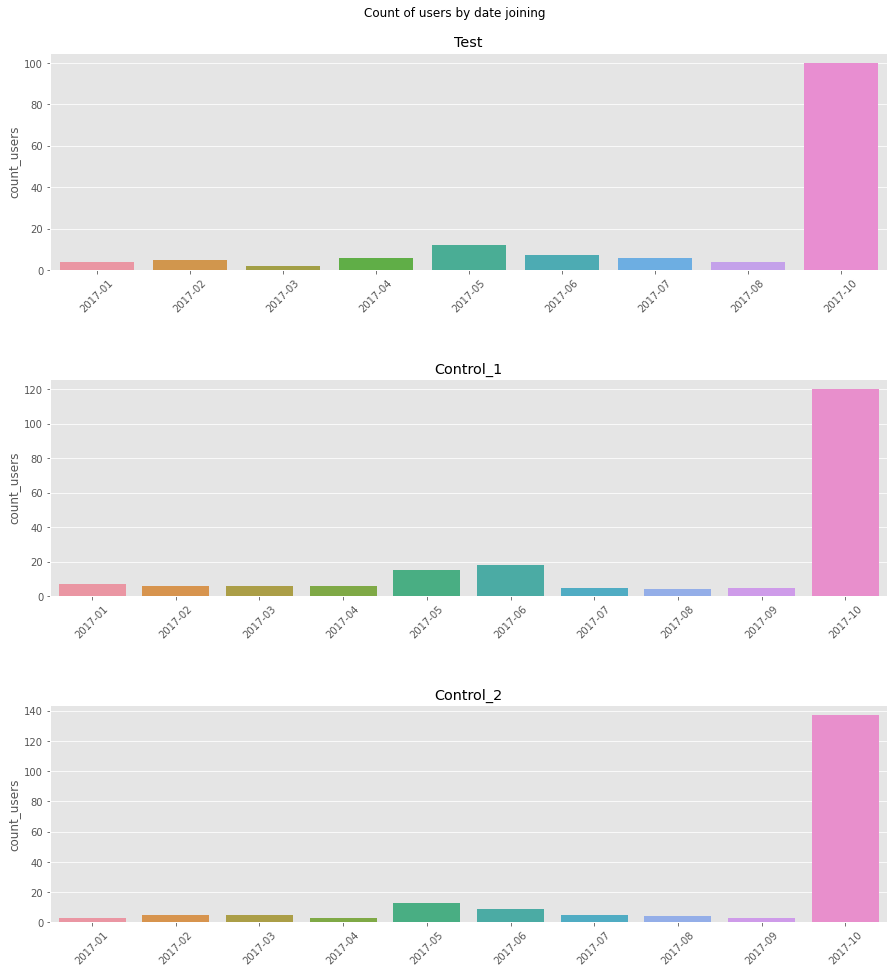

In [22]:
# Построение графиков
plt.figure(figsize=(15, 16))
plt.suptitle("Count of users by date joining", y=0.92)

plt.subplot(3, 1, 1)
sns.barplot(x="year_month", y="count_users", data=date_joined_test);
plt.xticks(rotation=45);
plt.title("Test")
plt.xlabel("")

plt.subplot(3, 1, 2)
sns.barplot(x="year_month", y="count_users", data=date_joined_control_1);
plt.xticks(rotation=45);
plt.title("Control_1");
plt.xlabel("")

plt.subplot(3, 1, 3)
sns.barplot(x="year_month", y="count_users", data=date_joined_control_2);
plt.xticks(rotation=45);
plt.title("Control_2");
plt.xlabel("")

plt.subplots_adjust(hspace = 0.5)

**Вывод:** во всех группах данные с января по октябрь 2017 года, но в группе control_1 есть юзеры регистрацией в 2015 году (их удалим).

In [23]:
# Удаление данных за 2015 год

transactions_control_1 = transactions_control_1.query("joined_at > '2017-01'")

### 1.2. Количество юзеров по  странам в transactions

In [24]:
# Подсчет количества юзеров по странам 

country_B = transactions_test.groupby('country', as_index=False).agg(count_users=('uid', 'nunique')).sort_values('country')
country_A_1 = transactions_control_1.groupby('country', as_index=False).agg(count_users=('uid', 'nunique')).sort_values('country')
country_A_2 = transactions_control_2.groupby('country', as_index=False).agg(count_users=('uid', 'nunique')).sort_values('country')

In [25]:
# Объединение таблиц с подсчетом количества юзеров по странам 

country_A = country_A_1.merge(country_A_2, how='outer', on='country')
country = country_B.merge(country_A, how='outer', on='country')
country = country.rename(columns={'count_users': 'Test', 'count_users_x': 'Control_1', 'count_users_y': 'Control_2'})
country

,country,Test,Control_1,Control_2
0,Argentina,7.0,12.0,10.0
1,Australia,1.0,3.0,2.0
2,Belgium,4.0,4.0,10.0
3,Canada,6.0,9.0,4.0
4,Chile,4.0,10.0,11.0
5,France,13.0,22.0,19.0
6,Germany,7.0,5.0,5.0
7,Israel,5.0,14.0,6.0
8,Italy,9.0,17.0,16.0
9,Latvia,1.0,NaN,NaN


**Вывод**: контрольные группы отличаются по странам. Исключим пользователей из India, Austria, Lithuania, Ukraine

In [26]:
# Создание списка стран, которые будут исключены из датасетов
exclude_country = ['India', 'Austria', 'Lithuania', 'Ukraine']

In [27]:
transactions_control_1 = transactions_control_1.astype({'country': 'str'})

In [28]:
# Удаление стран
transactions_control_1 = transactions_control_1.query("country not in @exclude_country")

In [30]:
# Проверка
transactions_control_1.query("country in ['India', 'Austria', 'Lithuania', 'Ukraine']")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,year_month


### 1.3. Количество юзеров по полу

In [31]:
# Добавление колонки с обозначением контрольной группы
users_test['experiment_group'] = 'test'
users_control_1['experiment_group'] = 'control_1'
users_control_2['experiment_group'] = 'control_2'


# Объединение таблиц в одну
users = pd.concat([users_test, users_control_1, users_control_2], ignore_index=True)

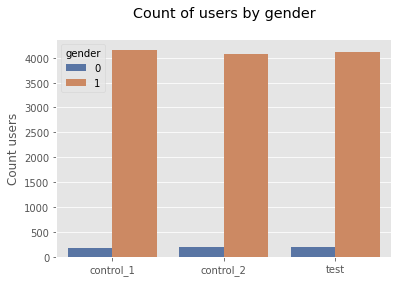

In [32]:
# Распределение пользователей в контрольных группах по полу (0 - женщины, 1 - мужчины)

users_gender = users.groupby(['experiment_group', 'gender'], as_index=False).agg(count_gender=('uid', 'nunique'))
ax=sns.barplot(
    x='experiment_group', 
    y='count_gender', 
    data=users_gender, 
    hue='gender',
    palette='deep',);
ax.set(xlabel='', ylabel='Count users', title='Count of users by gender\n');

**Вывод:** распределение пользователей по полу во всех группах примерно одинаковое. Стоит отметить, что женщин в выборках намного меньше, чем мужчин. Далее при проведении A/B теста нецелесообразно проводить разбивку по полу. 

### 1.4. Распредлениие пользователей по возрасту

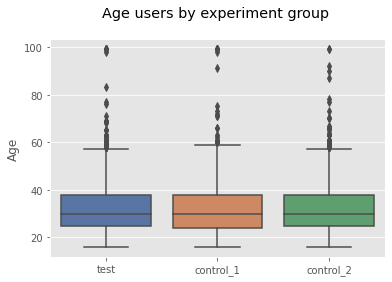

In [33]:
# Распределение пользователей по возрасту

ax=sns.boxplot(
    x='experiment_group', 
    y='age', 
    data=users, 
    palette='deep');
ax.set(xlabel='', ylabel='Age', title='Age users by experiment group \n');

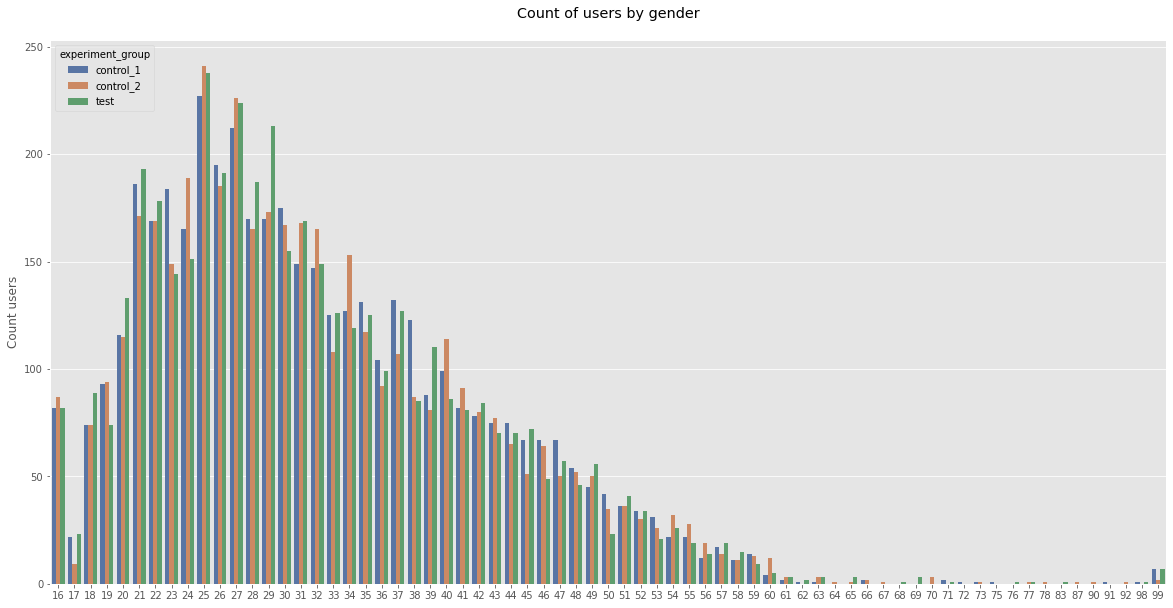

In [34]:
users_age = users.groupby(['experiment_group', 'age'], as_index=False).agg(count_age=('uid', 'nunique'))
plt.figure(figsize=(20, 10))
ax=sns.barplot(
    x='age', 
    y='count_age', 
    data=users_age, 
    hue='experiment_group',
    palette='deep',);
ax.set(xlabel='', ylabel='Count users', title='Count of users by gender\n');

**Вывод:** распределение пользователей по возрастам во всех группах примерно одинаковое (медианы равны во всех трех группах), присутсвуют выбросы. Очень высокий возраст пользователй можно объяснить тем, что часть людей указали его неверно. 

## 2. Проведение A/A теста

Перед проведение A/B теста проверим корректность работы системы спллитования. При проведении A/A теста будет оценена основная метрика CR в покупку premium_no_trial, ARPU, ARPPU.

In [35]:
# Добавление колонки с обозначением экспериментальной группы

users_control_1['experiment_group'] = 'A_1'
users_control_2['experiment_group'] = 'A_2'

# Объединение таблиц в одну

users = pd.concat([users_control_1, users_control_2], ignore_index=True)

transactions_control_1['experiment_group'] = 'A_1'
transactions_control_2['experiment_group'] = 'A_2'

pd.options.mode.chained_assignment = None

# Объединение таблиц в одну

transactions = pd.concat([transactions_control_1, transactions_control_2], ignore_index=True)

In [36]:
# Отбор пользователей, оплативших premium_no_trial впервые
first_premium = transactions.query("product_type=='premium_no_trial'") \
                            .groupby('uid', as_index=False) \
                            .agg(first_premium=('paid_at', 'min')) 

In [37]:
# Присвоение 1 первой покупке premium_no_trial

first_premium['purchase_premium'] = 1

In [38]:
# Объединение таблиц users_control и first_premium

users_premium = users.merge(first_premium, how='left', on='uid')

In [39]:
# Замена NaN  в колонке 'purchase_premium' на 0

users_premium['purchase_premium'] = users_premium.purchase_premium.fillna(0)

In [40]:
# Расчет конверсии

conversion_control = users_premium.groupby('experiment_group', as_index = False) \
                       .agg({'purchase_premium': 'mean'}) \
                       .rename(columns = {'purchase_premium': 'conversion'})

conversion_control['conversion'] = conversion_control.conversion.apply(lambda x: round(x*100, 3))
conversion_control

,experiment_group,conversion
0,A_1,2.235
1,A_2,2.392


### 2.2. Проверка на равенство дисперсий

In [41]:
st.levene(users_premium.query("experiment_group == 'A_1'").purchase_premium, 
          users_premium.query("experiment_group == 'A_2'").purchase_premium, center='mean')

LeveneResult(statistic=0.9396302932956238, pvalue=0.33240019272913945)

Дисперсии равны

In [42]:
st.levene(transactions.query("experiment_group == 'A_1'").revenue, 
          transactions.query("experiment_group == 'A_2'").revenue, center='mean')

LeveneResult(statistic=5.493377957803269, pvalue=0.01936824176674399)

Дисперсии не равны, применяем непараметрический t-тест 

In [43]:
st.levene(users.query("experiment_group == 'A_1'").total_revenue, 
          users.query("experiment_group == 'A_2'").total_revenue, center='mean')

LeveneResult(statistic=5.089485690322151, pvalue=0.024096338343375552)

In [ ]:
Дисперсии не равны, применяем непараметрический t-тест 

**Гипотезы для A/A теста**

H_0 - нет статистически значимых различий между контрольными группами

H_1 - контрольные группы статистически значимо различаются 

Примем уровень значимости альфа равным 0,05

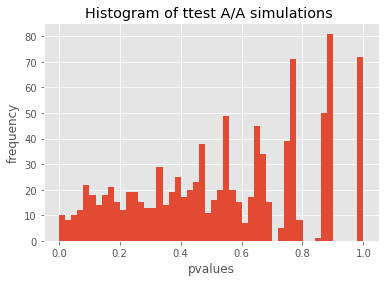

0.019

In [44]:
# A/A тест по CR в premium_no_trial

n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = users_premium.query("experiment_group == 'A_1'").purchase_premium.sample(n_s, replace = False).values
    s2 = users_premium.query("experiment_group == 'A_2'").purchase_premium.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations

In [45]:
transactions_ARPPU = transactions.groupby(['uid', 'experiment_group'],as_index=False) \
                                .agg(total_revenue=('revenue', 'sum'))[['uid', 'experiment_group', 'total_revenue']]

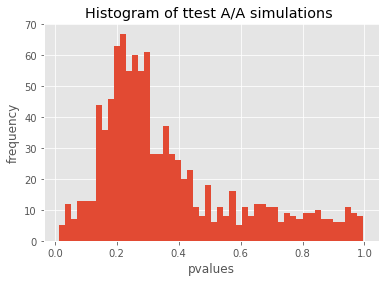

0.014

In [46]:
# A/A тест по ARPPU

n = 100000
simulations = 1000
n_s = 100
res = []

for i in tqdm(range(simulations)):
    s1 = transactions_ARPPU.query("experiment_group == 'A_1'").total_revenue.sample(n_s, replace = False).values
    s2 = transactions_ARPPU.query("experiment_group == 'A_2'").total_revenue.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations

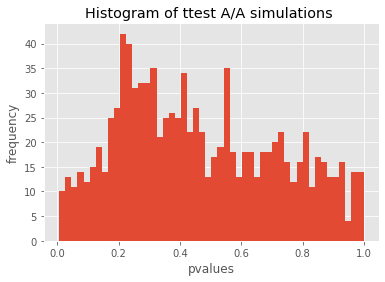

0.025

In [47]:
# A/A тест по ARPU

n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = users.query("experiment_group == 'A_1'").total_revenue.sample(n_s, replace = False).values
    s2 = users.query("experiment_group == 'A_2'").total_revenue.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations

**Вывод:** во всех трех случаях p-value < 0.05, следовательно система сплитования работает корректно.

## 3. A/B тест

In [48]:
#Добавим в каждую таблицу столбец с обозначением экспериментальной группы и объединим три таблицы в одну

users_test['experiment_group'] = 'B'
users_control_1['experiment_group'] = 'A'
users_control_2['experiment_group'] = 'A'

users_AB = pd.concat([users_test, users_control_1, users_control_2], ignore_index=True)

transactions_test['experiment_group'] = 'B'
transactions_control_1['experiment_group'] = 'A'
transactions_control_2['experiment_group'] = 'A'

transactions_AB = pd.concat([transactions_test, transactions_control_1, transactions_control_2], ignore_index=True)

### CR

In [58]:
# Для каждого юзера отберем только первую покупку premium_no_trial
tr_premium = transactions_AB.query("product_type=='premium_no_trial'") \
                            .groupby('uid', as_index=False) \
                            .agg(first_purchase=('paid_at', 'min')) 

(266, 2)

In [59]:
# Присвоение значения 1, если пользователь приобрел premium_no_trial
tr_premium['first_purchase'] = 1

In [61]:
# Объединение таблиц

u_premium = users_AB.merge(tr_premium, how='left', on='uid')

In [62]:
# Замена пропущенных значений в колонке first_purchase на 0

u_premium['first_purchase'] = u_premium.first_purchase.fillna(0)

In [64]:
# Расчет CR

u_cr = u_premium.groupby('experiment_group', as_index = False) \
                       .agg(conversion=('first_purchase', 'mean')) 

u_cr['conversion'] = u_cr.conversion.apply(lambda x: round(x*100, 3))
u_cr

,experiment_group,conversion
0,A,2.313
1,B,1.555


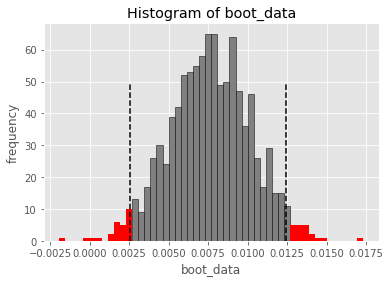

In [65]:
booted_data = get_bootstrap(u_premium.query("experiment_group == 'A'").first_purchase, 
                            u_premium.query("experiment_group == 'B'").first_purchase)

In [66]:
booted_data["p_value"] # альфа

0.002589147781768342

In [67]:
booted_data["quants"] # ДИ

,0
0.025,0.002578
0.975,0.012455


p_value<0.05 Отклоняем H_0 различия статистически значимы

### ARPU

In [49]:
users_AB.groupby('experiment_group', as_index=False).agg(ARPU=('total_revenue', 'mean'))

,experiment_group,ARPU
0,A,526.818805
1,B,544.313138


In [50]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

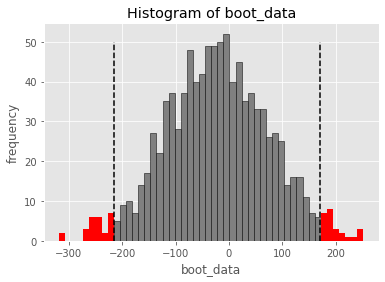

In [51]:
booted_data = get_bootstrap(users_AB.query("experiment_group == 'A'").total_revenue, 
                            users_AB.query("experiment_group == 'B'").total_revenue)

In [52]:
booted_data["p_value"] # альфа

0.8196795667205342

In [53]:
booted_data["quants"] # ДИ

,0
0.025,-215.489329
0.975,171.184770


p_value>0.05 Принимаем H_0 различия статистически не значимы

### ARPPU

In [54]:
transactions_AB.groupby('experiment_group', as_index=False).agg(ARPPU=('revenue', 'mean'))

,experiment_group,ARPPU
0,A,6460.461429
1,B,8589.380952


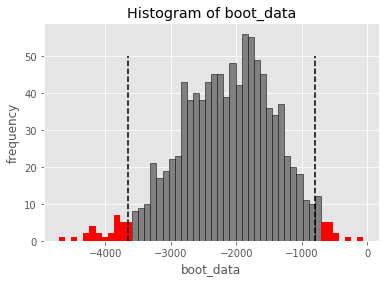

In [55]:
booted_data = get_bootstrap(transactions_AB.query("experiment_group == 'A'").revenue, 
                            transactions_AB.query("experiment_group == 'B'").revenue)

In [56]:
booted_data["p_value"] # альфа

0.003461686525542358

In [57]:
booted_data["quants"] # ДИ

,0
0.025,-3660.409667
0.975,-795.885964


p_value<0.05 Отклоняем H_0 различия статистически значимы

**Выводы:** различия в метриках ARPPU и CR статистически значимы, ARPU - статистически не значимы. В результате эксперимента:
- CR в premium_no_trial уменьшилась 
- ARPPU увеличилась 

Для заключения об успешности эксперимента посомтрим на изменение метрики Retention Rate.

## Retention Rate
Retention будем расчитывать на 1, 7 и 28 дни. Обзор данных показал, что большинство пользователей заходили в приложение каждый день, поэтому retenrion будет расчитан исходя из суммарного количества дней. 

In [69]:
# Замена пропущенных значений в колонке visit_days на 0
users_AB['visit_days'] = users_AB.visit_days.fillna(0)

In [70]:
# Создание колонки с суммарным количеством дней

users_AB['count_visit_days'] = users_AB.visit_days.apply(lambda x: len(str(x).split(',')) if x != 0 else 0)

In [79]:
# Расчет RR первого дня
first_day = users_AB.query("count_visit_days != 0")
first_day['first_day'] = 1
first_day = first_day[['uid', 'first_day']]

RR_1 = users_AB.merge(first_day, how='left', on='uid')
RR_1['first_day'] = RR_1.first_day.fillna(0)
RR_1 = RR_1.groupby('experiment_group', as_index=False).agg(RR_1=('first_day', 'mean'))
RR_1['RR_1'] = RR_1.RR_1.apply(lambda x: round(x*100, 3))
RR_1

,experiment_group,RR_1
0,A,68.759
1,B,69.127


In [80]:
# Расчет RR седьмого дня
seventh_day = users_AB.query("count_visit_days >= 7")
seventh_day['seventh_day'] = 1
seventh_day = seventh_day[['uid', 'seventh_day']]

RR_7 = users_AB.merge(seventh_day, how='left', on='uid')
RR_7['seventh_day'] = RR_7.seventh_day.fillna(0)
RR_7 = RR_7.groupby('experiment_group', as_index=False).agg(RR_7=('seventh_day', 'mean'))
RR_7['RR_7'] = RR_7.RR_7.apply(lambda x: round(x*100, 3))
RR_7

,experiment_group,RR_7
0,A,25.093
1,B,25.116


In [73]:
# Расчет RR 28 дня
days_28 = users_AB.query("count_visit_days == 28")
days_28['days_28'] = 1
days_28 = days_28[['uid', 'days_28']]

RR_28 = users_AB.merge(days_28, how='left', on='uid')
RR_28['days_28'] = RR_28.days_28.fillna(0)
RR_28.groupby('experiment_group', as_index=False).agg(RR_28=('days_28', 'mean'))

,experiment_group,RR_28
0,A,0.002441
1,B,0.002321


## Для +30

In [154]:
u_cr_30 = u_premium.query("age > 30") \
                        .groupby('experiment_group', as_index = False) \
                       .agg(conversion=('first_purchase', 'mean')) 

u_cr_30['conversion'] = u_cr_30.conversion.apply(lambda x: round(x*100, 3))
u_cr_30

,experiment_group,conversion
0,A,1.759
1,B,1.820
